In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import normaltest
from sklearn import preprocessing

%matplotlib inline

matplotlib.style.use('seaborn-pastel')

In [3]:
def convert_to_float(value):
    """
    Transforms argument value to float;
    Replaces the comma in a string variable with a dot and rounds the value to two decimal places;
    
    """
    return round(float(str(value).replace(",", ".")), 2)

In [4]:
# Загрузка датасета;
df = pd.read_csv('../data/textiles.csv', sep=';')

In [5]:
# Сохраняем только необходимые колонки датасета;
df = df[['internal_storage', 'warp_size', 'weft_size', 'type', 'item_no', 'warp_a', 'warp_b',\
        'weft_a', 'weft_b', 'warp_dens', 'weft_dens']]

In [6]:
# Приведение типов колонок датафрейма к веществнному значению;
df.warp_a = df.warp_a.apply(convert_to_float)
df.warp_b = df.warp_b.apply(convert_to_float)
df.weft_a = df.weft_a.apply(convert_to_float)
df.weft_b = df.weft_b.apply(convert_to_float)

In [7]:
# Получение средних значений толщин нитей по основе и по утку;
df['warp_nominal'] = round((df.warp_a + df.warp_b) / 2, 2)
df['weft_nominal'] = round((df.weft_a + df.weft_b) / 2, 2)

### Пропущенные значения

In [8]:
print("Количество пропущенных значений - толщина_по_основе_1 - " + str(df.warp_a.isna().sum()))
print("Количество пропущенных значений - толщина_по_основе_2 - " + str(df.warp_b.isna().sum()))
print("Количество пропущенных значений - толщина_по_утку_1 - " + str(df.weft_a.isna().sum()))
print("Количество пропущенных значений - толщина_по_утку_2 - " + str(df.weft_b.isna().sum()))

print("" + str(df.warp_nominal.isna().sum()))
print("" + str(df.weft_nominal.isna().sum()))

print("" + str(df.warp_dens.isna().sum()))
print("" + str(df.weft_dens.isna().sum()))

Количество пропущенных значений - толщина_по_основе_1 - 0
Количество пропущенных значений - толщина_по_основе_2 - 0
Количество пропущенных значений - толщина_по_утку_1 - 0
Количество пропущенных значений - толщина_по_утку_2 - 0
0
0
1
1


In [9]:
print(len(df))
df = df.dropna(how='any')
print(len(df))

303
302


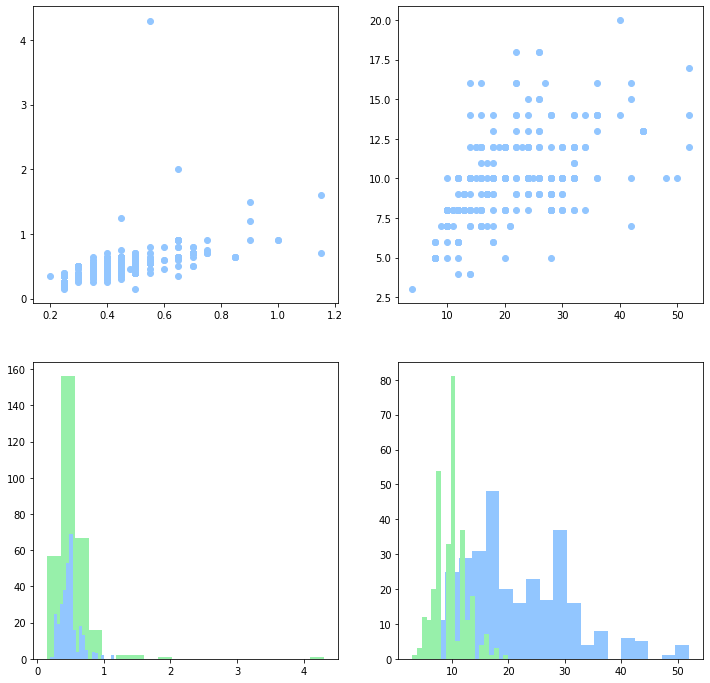

In [10]:
# Графики распределения основных численных параметров;
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0][0].scatter(df.warp_nominal, df.weft_nominal)
ax[0][1].scatter(df.warp_dens, df.weft_dens)
ax[1][0].hist(df.warp_nominal, bins=20, zorder=1) 
ax[1][0].hist(df.weft_nominal, bins=20, zorder=0)
ax[1][1].hist(df.warp_dens, bins=20, zorder=0)
ax[1][1].hist(df.weft_dens, bins=20, zorder=1)

plt.show()

### Проверка нормальности распределения величин

In [11]:
alpha = 1e-3

In [12]:
k1, p1 = normaltest(df.warp_nominal.to_list())
k2, p2 = normaltest(df.weft_nominal.to_list())
k3, p3 = normaltest(df.warp_dens.to_list())
k4, p4 = normaltest(df.weft_dens.to_list())

# Нулевая гипотеза при проверке распределения - признак распределён нормально;

if p1 < alpha:
    print("Толщина нити по основе - нулевая гипотеза отвергается")
else:
    print("Толщина нити по основе - нулевая гипотеза принимается")

if p2 < alpha:
    print("Толщина нити по утку - нулевая гипотеза отвергается")
else:
    print("Толщина нити по утку - нулевая гипотеза принимается")
    
if p3 < alpha:
    print("Плотность по основе - нулевая гипотеза отвергается")
else:
    print("Плотность по основе - нулевая гипотеза принимается")

if p4 < alpha:
    print("Плотность по утку - нулевая гипотеза отвергается")
else:
    print("Плотность по утку - нулевая гипотеза принимается")

Толщина нити по основе - нулевая гипотеза отвергается
Толщина нити по утку - нулевая гипотеза отвергается
Плотность по основе - нулевая гипотеза отвергается
Плотность по утку - нулевая гипотеза отвергается


## Определение выбросов в данных

Для начала построим боксплоты для всех рассматриваемых численных параметров

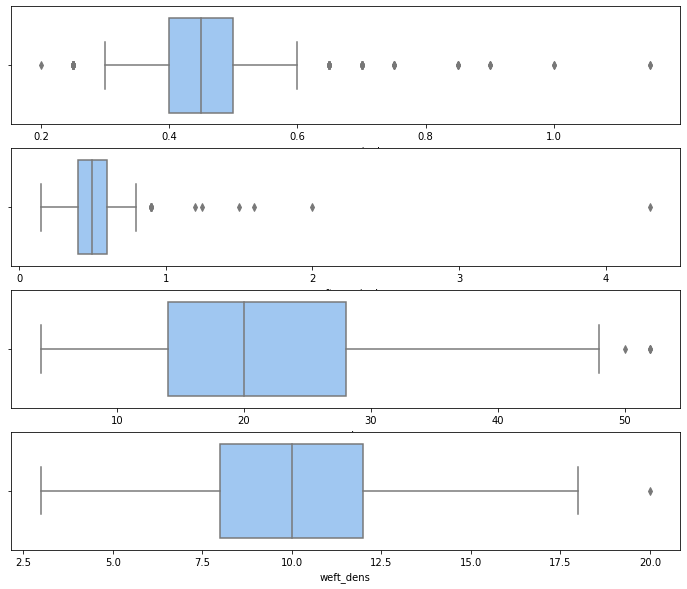

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

sns.boxplot(ax=ax[0], x=df.warp_nominal)
sns.boxplot(ax=ax[1], x=df.weft_nominal)
sns.boxplot(ax=ax[2], x=df.warp_dens)
sns.boxplot(ax=ax[3], x=df.weft_dens)

plt.savefig('../images/boxplots.png')

Как можно заметить, и по тощине нитей основы, и по толщине нитей утка имеется некторое количество выбросов  
То же справделиво и для плотностей тканей, хотя, в данном случае количество выбросов представляется меньшим  

##### Определим выбросы в данных по межквартильному интервалу

In [14]:
def remove_outliers(df, column):
    """ """
    
    def _remove_outliers(df, column):
        """ """
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iq_range = q3 - q1  # Interquartile range;
        low_fence  = q1 - 1.5 * iq_range
        high_fence = q3 + 1.5 * iq_range
        df_out = df.loc[(df[column] > low_fence) & (df[column] < high_fence)]
        return df_out

    if type(column) is list:
        for column_name in column:
            df = _remove_outliers(df, column_name)
        return df
    elif type(column) is str:
        return _remove_outliers(df, column)

In [15]:
# получение выбросов по толщинам нитей;
cleared_thick_warp = remove_outliers(df, 'warp_nominal')
cleared_thick_weft = remove_outliers(df, 'weft_nominal')

In [16]:
# получение выбросов по плотностям тканей;
cleared_dens_warp = remove_outliers(df, 'warp_dens')
cleared_dens_weft = remove_outliers(df, 'weft_dens')

In [17]:
cleared_thick = remove_outliers(df, ['warp_nominal', 'weft_nominal'])
cleared_dens = remove_outliers(df, ['warp_dens', 'weft_dens'])

In [18]:
outliers_thick = pd.concat([df, cleared_thick]).drop_duplicates(keep=False)
outliers_dens = pd.concat([df, cleared_dens]).drop_duplicates(keep=False)

In [19]:
outliers = pd.concat([outliers_thick, outliers_dens]).drop_duplicates(keep=False)
cleared = pd.concat([df, outliers]).drop_duplicates(keep=False)

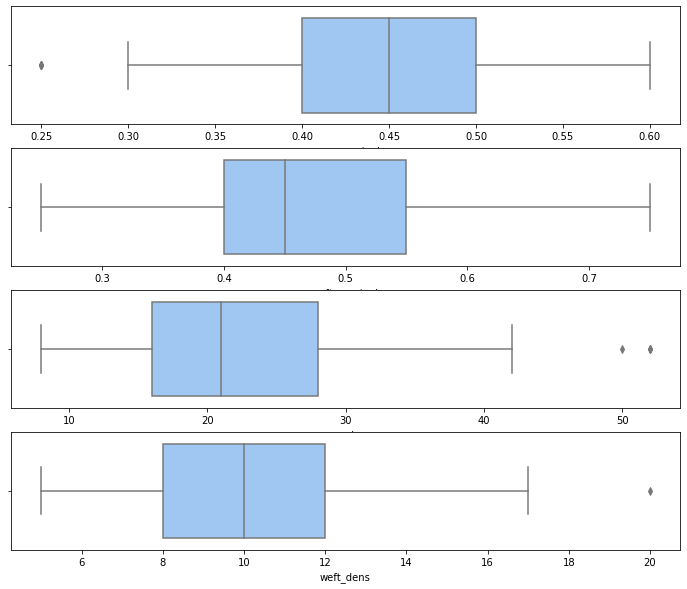

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

sns.boxplot(ax=ax[0], x=cleared.warp_nominal)
sns.boxplot(ax=ax[1], x=cleared.weft_nominal)
sns.boxplot(ax=ax[2], x=cleared.warp_dens)
sns.boxplot(ax=ax[3], x=cleared.weft_dens)

plt.savefig('../images/boxplots_no_outliers.png')

plt.show()

### Нормализация и стандартизация признаков

In [21]:
warp_nominal_norm, weft_nominal_norm = preprocessing.normalize([
    cleared.warp_nominal.to_list(), cleared.weft_nominal.to_list()
])

warp_nominal_scaled = preprocessing.scale(cleared.warp_nominal.to_list())
weft_nominal_scaled = preprocessing.scale(cleared.weft_nominal.to_list())

cleared['warp_nominal_norm'] = warp_nominal_norm
cleared['weft_nominal_norm'] = weft_nominal_norm
cleared['warp_nominal_scaled'] = warp_nominal_scaled
cleared['weft_nominal_scaled'] = weft_nominal_scaled

#*********************************************************************************************************************#

warp_dens_norm, weft_dens_norm = preprocessing.normalize([
    cleared.warp_dens.to_list(), cleared.weft_dens.to_list()
])

warp_dens_scaled = preprocessing.scale(cleared.warp_dens)
weft_dens_scaled = preprocessing.scale(cleared.weft_dens)

cleared['warp_dens_norm'] = warp_dens_norm
cleared['weft_dens_norm'] = weft_dens_norm
cleared['warp_dens_scaled'] = warp_dens_scaled
cleared['weft_dens_scaled'] = weft_dens_scaled

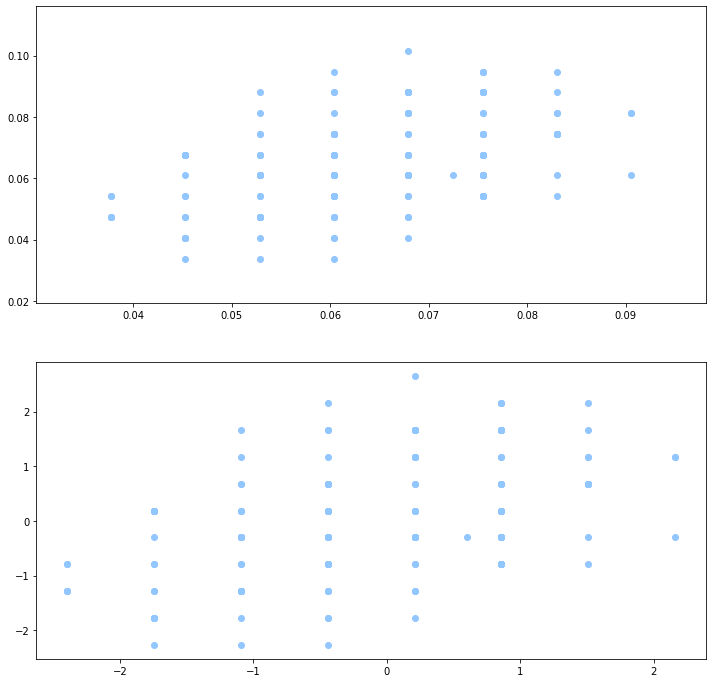

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].scatter(cleared.warp_nominal_norm, cleared.weft_nominal_norm)
ax[1].scatter(cleared.warp_nominal_scaled, cleared.weft_nominal_scaled)

plt.show()

Распределение тощин нитей, к сожалению, выглядит несколько "неестественно" вследствие невысокой точности измерения самих нитей - допускаемая точность составляла +-0.5 мм;

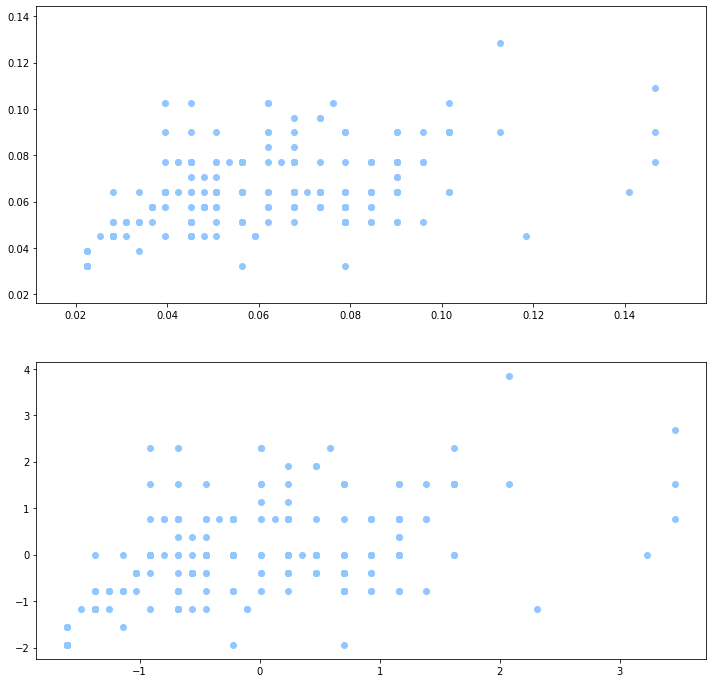

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].scatter(cleared.warp_dens_norm, cleared.weft_dens_norm)
ax[1].scatter(cleared.warp_dens_scaled, cleared.weft_dens_scaled)

plt.show()

### Сохранение полученных датасетов

In [24]:
cleared.to_csv('../data/cleared.csv')